# Analysis of the dataset: Gray_whale

In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
import os
import json
from utils import plot_names

%matplotlib inline

## Load annotations
This section is the same for all datasets. 

Update `dataDir` with the location of the data.

In [2]:
species = 'whale_grey' # 'snowleopard' # 'whaleshark'
dataDir='/home/olga/Datasets/coco.{}/coco'.format(species)
dataType= 'test2021' #'test2020' #'train2020'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

#  Uncomment the line below if the data has been cleaned previously, use cleaned file
#annFile='{}/annotations/instances_{}_cleaned.json'.format(dataDir,dataType)

Initialize COCO api for instance annotations:

In [3]:
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


Display COCO categories and supercategories:

In [4]:
cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
whale_grey

COCO supercategories: 
animal


Load and display instance annotations:

{'license': 3, 'file_name': '000000002611.jpg', 'photographer': '', 'coco_url': None, 'height': 490, 'width': 2400, 'date_captured': '2006-09-01 12:55:39', 'gps_lat_captured': '-1.000000', 'gps_lon_captured': '-1.000000', 'flickr_url': None, 'id': 2611, 'uuid': 'c2e79c24-e449-ded3-de4c-c24d56f13531'}
Name: eb163fec-8bda-4a59-90e9-0f7a3891b592 Viewpoint: right


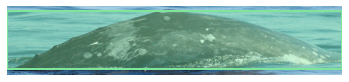

In [5]:
catIds = coco.getCatIds(catNms=nms);
imgIds = coco.getImgIds(catIds=catIds);

img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print('Name: {} Viewpoint: {}'.format(anns[0]['name'], anns[0]['viewpoint']))
coco.showAnns(anns)
#anns

In [6]:
print('Total number of annotations: {}'.format(len(coco.getAnnIds(imgIds))))

Total number of annotations: 7047


## Analyse viewpoints

Collect `viewpoint` annotation, select unique viewpoints and compute how many annotations per viewpoint.

Note:
This dataset has some `None` values that are stored as a `None` object. Convert them to string `"None"` to process the whole array as a string array by numpy.

In [7]:
all_anns = coco.loadAnns(coco.getAnnIds())

ids_anns = np.array([ann['id'] for ann in all_anns])

views_anns = np.array([ann['viewpoint'] if ann['viewpoint'] is not None else 'None' for ann in all_anns])

views, views_counts = np.unique(views_anns, return_counts=True)
views, views_counts

(array(['left', 'right'], dtype='<U5'), array([3467, 3580]))

The number of annotations with `None` viewpoint is only 10 out of more than 7,000 images and can be safely removed from the training set.

Plot bar chart:

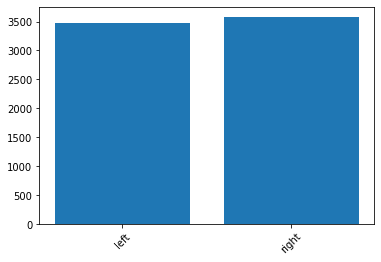

In [8]:
plt.bar(views, views_counts)
plt.xticks(rotation=45)
plt.show()

## Analyse names

Collect `name` annotation, select unique names and compute how many annotations per name.

In [9]:
names_anns = np.array([ann['name'] for ann in all_anns])
names, names_count = np.unique(names_anns, return_counts=True)
print('Found {} unique names'.format(len(names)))

Found 2175 unique names


Plot bar chart:

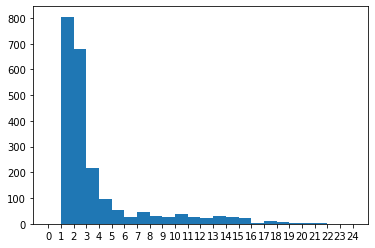

In [10]:
bins = list(range(25))
plt.hist(names_count, bins=bins)
plt.xticks(bins)
plt.show()

Print exact exact numbers for clarity:

In [11]:
for num in range(1, 30):
    print('{} names have {} image'.format((names_count == num).sum(), num))

805 names have 1 image
679 names have 2 image
217 names have 3 image
96 names have 4 image
53 names have 5 image
27 names have 6 image
44 names have 7 image
29 names have 8 image
26 names have 9 image
38 names have 10 image
27 names have 11 image
22 names have 12 image
31 names have 13 image
26 names have 14 image
22 names have 15 image
4 names have 16 image
10 names have 17 image
6 names have 18 image
5 names have 19 image
3 names have 20 image
2 names have 21 image
1 names have 22 image
1 names have 23 image
0 names have 24 image
0 names have 25 image
1 names have 26 image
0 names have 27 image
0 names have 28 image
0 names have 29 image


A small number of images has name `'____'`. 

In [12]:
print('Number of images with no name: {}'.format(len(views_anns[names_anns=='____'])))

Number of images with no name: 0


78 images is a small subset of the dataset and can be safely removed before training.

Let's check what viewpoints these names have:

In [13]:
views_anns[names_anns=='____']

array([], dtype='<U5')

Get an array of filenames and bounding boxes for display purposes:

In [14]:
filenames = np.array([coco.loadImgs(ann['image_id'])[0]['file_name'] for ann in all_anns])
filenames = np.array(['%s/images/%s/%s'%(dataDir,dataType,f) for f in filenames])

bboxes = np.array([ann['segmentation_bbox'] for ann in all_anns])

Print images for a random name (new name is displayed every time the cell is executed):

Found 6 annots for name 4c9a5f9a-a5be-4677-891d-112acba9f2db


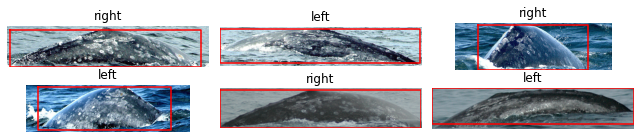

In [17]:
plot_names(names_anns, filenames, bboxes, views_anns, crop=False, max_display=15, ncols=3, ratio=(3,1))

The analysis shows that there are two views for each gray whale: left and right.
Left and right sides are different visually.
Each view will be identified separately. So the label (=identity) for the re-id network will be a combination of name and view.

# Clean data
After analysis of the data, we remove junk labels where `view == None` and `name == '____'` and save a new annotation file to ease further analysis.

In [4]:
with open(annFile, 'rb') as file:
    data = json.load(file)
    
print('Read {} items from json file {}\nwith keys {}'.format(len(data), annFile, data.keys()))

Read 6 items from json file /home/olga/Datasets/coco.whale_grey/coco/annotations/instances_test2021.json
with keys dict_keys(['info', 'licenses', 'categories', 'images', 'annotations', 'parts'])


In [5]:
cleaned_data = {}

In [6]:
cleaned_data['info'] = data['info']
cleaned_data['licenses'] = data['licenses']
cleaned_data['categories'] = data['categories']
cleaned_data['parts'] = data['parts']
cleaned_data['images'] = data['images']

In [8]:
cleaned_annotations = []
for ann in data['annotations']:
    if '____' not in ann['name'] and ann['viewpoint'] is not None:
        cleaned_annotations.append(ann)
        
print('Saved {} cleaned annotations out of {}'.\
      format(len(cleaned_annotations), len(data['annotations'])))

Saved 7047 cleaned annotations out of 7131


In [9]:
cleaned_data['annotations'] = cleaned_annotations

In [10]:
annFile_cleaned = '{}/annotations/instances_{}_cleaned.json'.format(dataDir,dataType)
with open(annFile_cleaned, 'w', encoding='utf-8') as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=4)

## Analyse combination name + viewpoint

Labels where `view == None` and `name == '____'` will be removed from the training/testing subsets.

Create new identity labels by concatenating `name` and `viewpoint`.

In [18]:
name_view_anns = np.array(['{}_{}'.format(n, v) for n, v in zip(names_anns, views_anns)])

name_views, name_views_count = np.unique(name_view_anns, return_counts=True)
print('Found {} unique name_views'.format(len(name_views)))

Found 3385 unique name_views


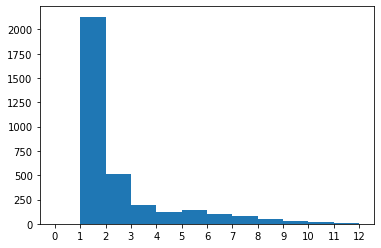

In [19]:
bins = list(range(13))
plt.hist(name_views_count, bins=bins)
plt.xticks(bins)
plt.show()

In [20]:
for num in range(1, 13):
    print('{} names have {} image'.format((name_views_count == num).sum(), num))

2131 names have 1 image
511 names have 2 image
196 names have 3 image
121 names have 4 image
140 names have 5 image
98 names have 6 image
76 names have 7 image
52 names have 8 image
31 names have 9 image
20 names have 10 image
4 names have 11 image
3 names have 12 image


Found 2 annots for name 0c3c9cdc-fd0c-48c6-afa0-2d046c33720f_left


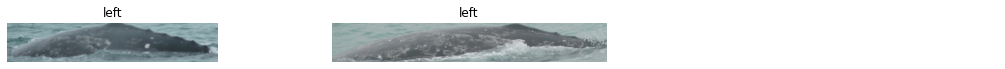

In [21]:
plot_names(name_view_anns, filenames, bboxes, views_anns, crop=True, max_display=15, ncols=3, ratio=(5,1))

# Create train/validation split as in PIE V1

## Training data 
Source: WildMe Training PIE V1

The training data was provided by Cascadia Research Collective and represents their grey whale catalog. Only IDs and photos were consistently provided. At our request, prior to training they did a manual review of the IDs to minimize possible labeling errors, where a researcher reviewed every photo for every name to confirm an accurate ID label. Filtering for only the whales with at least 3 sightings (a requirement for PIE training and validation), we had 2,012 right-side and 1,878 left-side photos of 359 identified individuals. 

When PIE is used on lateral views, we mirror every right-side image so that each picture PIE sees looks like a left-side image, ensuring the model is always seeing a standard orientation. During matching, viewpoints are already labeled and we do not compare rights to lefts or vice versa. This gives us several options for how to handle rights versus lefts in training. We explored training on all 3,890 right- and left-images in one go, splitting each individual into a right-name and a left-name so that the system does not confuse the two sides, but this did not improve validation accuracy over models trained on only one side. A possible reason for this is that the edge contour, which unlike the patterning is shared by both sides, is influencing PIE’s match rankings. We ultimately trained our model on all the right-side photos, leaving out the left-side photos from training to provide the robust validation accuracy numbers reported here.


In [27]:
left_names_anns = names_anns[views_anns == 'left']

In [28]:
left_names, left_names_counts = np.unique(left_names_anns, return_counts=True)
left_names

array(['0006c2e0-bf68-4c90-97db-34c67297d767',
       '0022c0e1-39da-47a0-a992-e2b571d145b8',
       '002390f4-2190-4aa4-aeee-e6a7ae6f27d3', ...,
       'ffa00428-9eca-45b5-b225-45317c03578c',
       'ffc25031-9205-4674-af36-5583cc65b7d0',
       'ffef76a0-946c-4798-871b-fb102b10c213'], dtype='<U36')

In [42]:
def analyse_unique(data_list, min_count):
    unique, counts = np.unique(data_list, return_counts=True)
    print('Found {} unique items'.format(len(unique)))
    plt.hist(counts)
    plt.show()
    
    # Analyse only unique items with counts >= min_count
    min_unique = unique[counts >= min_count]
    print('Found {} unique items with min count >= {}'.\
          format(len(min_unique), min_count))
    print('Total number of annotations {}'.format(sum(counts[counts >= min_count])))
    plt.hist(counts[counts >= min_count])
    plt.show()
    
    return unique, counts

Found 1702 unique items


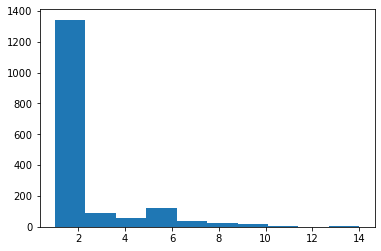

Found 359 unique items with min count >= 3
Total number of annotations 1879


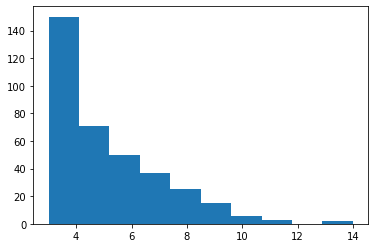

In [43]:
left_names, left_names_counts = analyse_unique(left_names_anns, min_count=3)

Found 1683 unique items


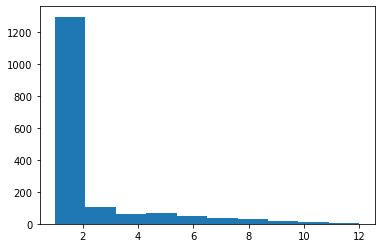

Found 384 unique items with min count >= 3
Total number of annotations 2015


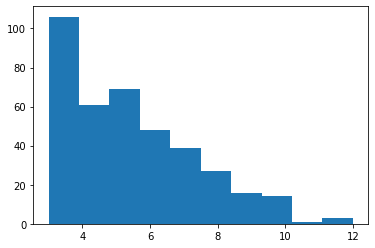

In [44]:
right_names_anns = names_anns[views_anns == 'right']
right_names, right_names_counts = analyse_unique(right_names_anns, min_count=3)

Record annotations id and split the data as right sides for training and left-sides for validation.

In [46]:
with open(annFile, 'rb') as file:
    data = json.load(file)
    
print('Read {} items from json file {}\nwith keys {}'.format(len(data), annFile, data.keys()))

Read 6 items from json file /home/olga/Datasets/coco.whale_grey/coco/annotations/instances_test2021_cleaned.json
with keys dict_keys(['info', 'licenses', 'categories', 'parts', 'images', 'annotations'])


In [53]:
def split_by_viewpoint(data, viewpoint, data_split_name):
    data_split = {}
    data_split['info'] = data['info']
    data_split['licenses'] = data['licenses']
    data_split['categories'] = data['categories']
    data_split['parts'] = data['parts']
    data_split['images'] = data['images']
    
    new_annotations = []
    for ann in data['annotations']:
        if ann['viewpoint'] == viewpoint:
            new_annotations.append(ann)

    print('Saved {} annotations with viwpoint {} out of {}'.\
          format(len(new_annotations), viewpoint, len(data['annotations'])))
    
    data_split['annotations'] = new_annotations
    
    annFile_split = '{}/annotations/instances_{}.json'.format(dataDir,data_split_name)
    with open(annFile_split, 'w', encoding='utf-8') as f:
        json.dump(data_split, f, ensure_ascii=False, indent=4)

In [54]:
split_by_viewpoint(data, viewpoint='right', data_split_name='train_right')

Saved 3580 annotations with viwpoint right out of 7047


In [55]:
split_by_viewpoint(data, viewpoint='left', data_split_name='test_left')

Saved 3467 annotations with viwpoint left out of 7047


## Split and display test annotations

There are many whales with only one or two sightings per side. One sighting per side is only useful in training as negatives or in testing as distructors.
We use images with 2 or 3 sighting for testing.
Let's plot some of the images

In [67]:
test_name_views = np.concatenate((name_views[name_views_count==2], name_views[name_views_count==3]))
print('Name_views with 2 or 3 sigtings: {} out of {}'.format(len(test_name_views), len(name_views)))

Name_views with 2 or 3 sigtings: 708 out of 3393


In [74]:
test_idx = np.isin(name_view_anns, test_name_views)

Found 2 annots for name 92403505-7010-4fe7-ae25-23b6eb30b53f_left
Found 3 annots for name fa905d8f-72c6-4ca5-8dd2-82a2030c4347_right
Found 2 annots for name 9cd3daea-c18d-4f72-a088-ebcb8cd27a34_right
Found 2 annots for name 1157628a-f66e-41fb-9973-e26305ee1ef5_left
Found 2 annots for name 144e37e5-de57-4f59-a8b2-03a43f51cac5_right
Found 2 annots for name d26ccdf8-9d4a-4752-95b8-05618b9fc499_left
Found 2 annots for name 75a10d1b-5059-4065-aa35-dd8b675f1509_left
Found 3 annots for name 38c51366-8129-4a2b-bbd0-36f4688ea969_left
Found 3 annots for name b0e36f7d-61db-43c8-908e-94b7f26382f3_right
Found 2 annots for name cf3d093e-f6f4-45b5-acfb-a68abcd54017_left


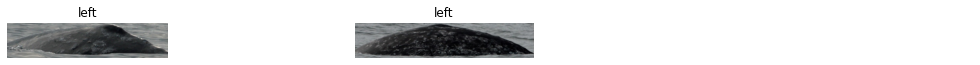

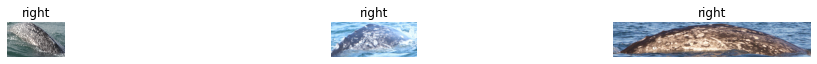

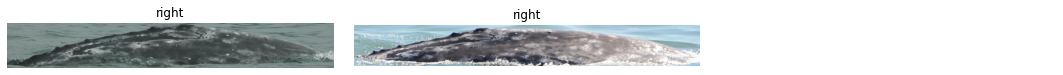

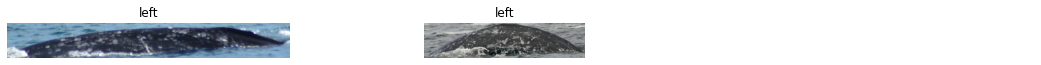

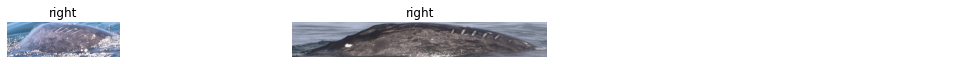

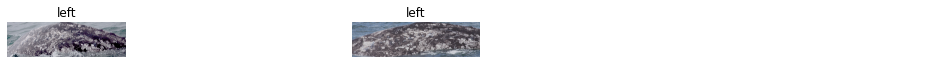

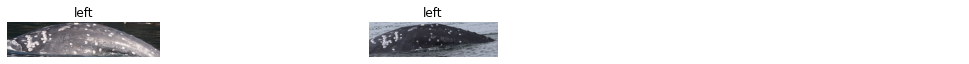

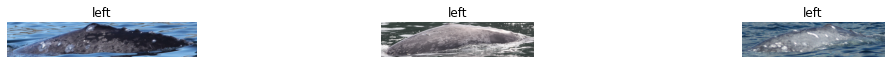

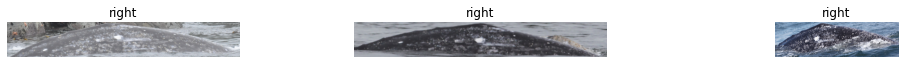

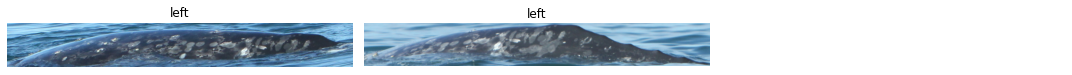

In [77]:
for _ in range(10):
    plot_names(
        name_view_anns[test_idx], 
        filenames[test_idx], 
        bboxes[test_idx], 
        views_anns[test_idx], 
        crop=True, 
        max_display=15, 
        ncols=3, 
        ratio=(5,1)
    )

## Remove junk annotations

Remove junk annotations, such as '____' for name and 'None' for view. Compute the number of training images left.

In [59]:
num_good_anns = len([ann for ann in name_view_anns if '____' not in ann and 'none' not in ann.lower()])
print('Number of good annotations: {} out of {}'.format(num_good_anns, len(name_view_anns)))

Number of good annotations: 7047 out of 7131


In [60]:
num_bad_anns = len([ann for ann in name_view_anns if '____' in ann or 'none' in ann.lower()])
print('Number of good annotations: {} out of {}'.format(num_bad_anns, len(name_view_anns)))

Number of good annotations: 84 out of 7131


## Analyse image sizes

Let's get an average image size to decide on the input size for the neural network. 

We actually need not the size of the whole image but the bounding box sizes and their w/h ratio.

COCO bounding box annotations has the format: [x, y, w, h]

An array with coordinates of bounding boxes was computed in the previous section for plotting.

In [50]:
bboxes

array([[ 546,  381, 1415,  217],
       [   0,   39, 2399,  416],
       [   0,   27, 2399,  482],
       ...,
       [ 180,  778, 1168,  338],
       [ 213,  733, 1631,  258],
       [ 665,  584, 1437,  291]])

In [51]:
w2h = np.array([w/h for _,_,w,h in bboxes])
w2h

array([6.52073733, 5.76682692, 4.97717842, ..., 3.4556213 , 6.32170543,
       4.93814433])

In [52]:
w2h.mean(), w2h.min(), w2h.max()

(5.494027668436627, 1.411836485661989, 13.630681818181818)

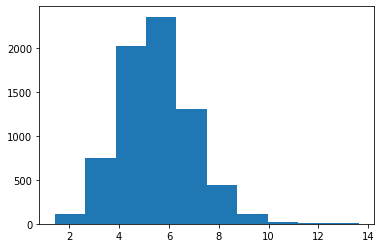

In [213]:
plt.hist(w2h)
plt.show()

Mean value for width to height ratio is 5.5.